#### **Workflow_And_Agents - LangGraph**

- **Workflows** are systems where LLMs and tools are orchestrated through predefined code paths. 

    Workflows are predefined sequences of tasks or operations designed to achieve a specific outcome. They follow a linear, rule-based structure where each step is executed in a set order. Workflows are particularly effective for automating repetitive tasks with clear, unchanging parameters. However, they lack the flexibility to adapt to unforeseen changes or complex scenarios not anticipated during their design. For instance, a workflow might automate the process of data entry by following a specific sequence of actions, but it would struggle to handle variations outside its programmed instructions.


- **Agents**, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

    Agents, on the other hand, are AI-driven entities capable of autonomous decision-making and action. Unlike workflows, agents can assess their environment, learn from it, and adjust their behavior accordingly. This enables them to handle complex, dynamic tasks without human intervention. For example, an AI agent in customer support can interpret diverse customer inquiries, access relevant databases, and provide tailored responses, all while learning from each interaction to improve future performance. This adaptability makes agents suitable for tasks requiring real-time decision-making and continuous learning.

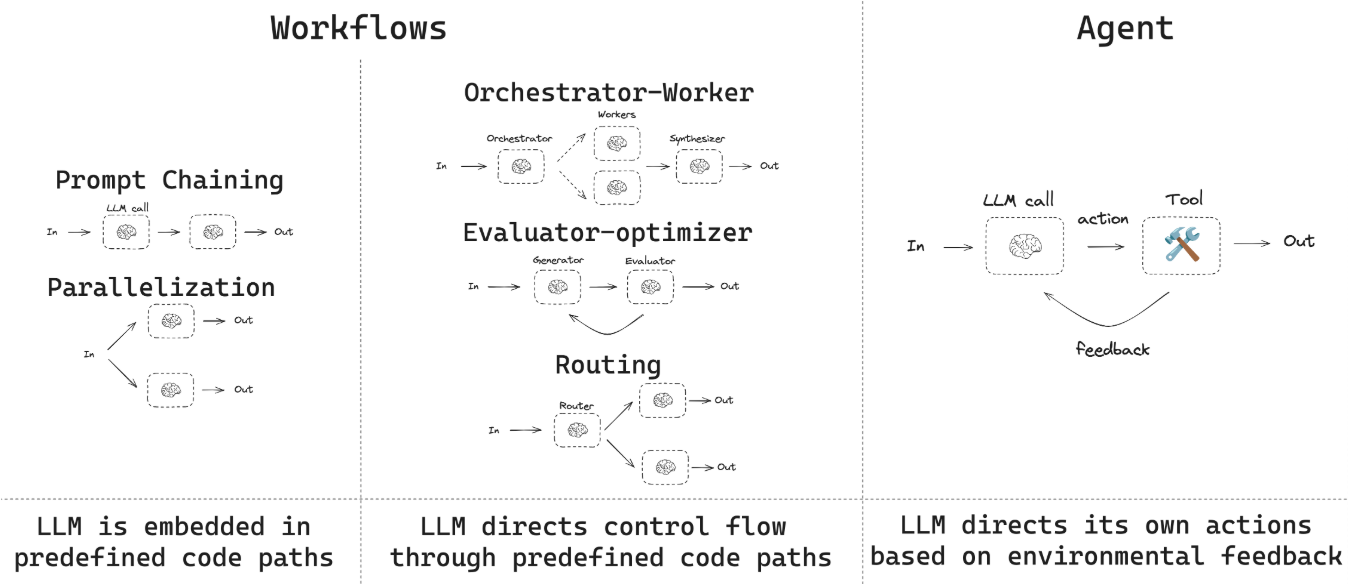

##### Building Blocks : The Augmented LLM

In [1]:
# Schema for structured output
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )
# LLM model
llm = ChatGroq(model="llama-3.2-11b-vision-preview",temperature=0)

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output)

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

search_query='Calcium CT score high cholesterol relationship' justification='user asked about the relationship between Calcium CT score and high cholesterol'


[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_cfdb',
  'type': 'tool_call'}]

##### Prompt Chaining

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

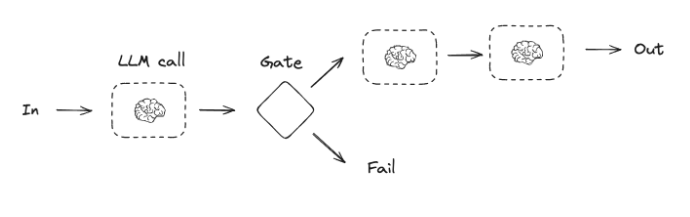

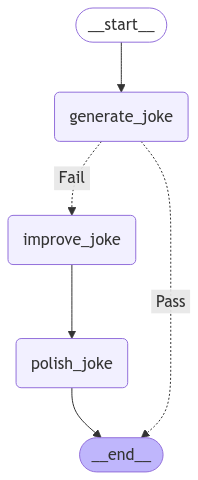

Initial joke:
Why did the cat join a band? 

Because it wanted to be the purr-cussionist.

--- --- ---

Improved joke:
Here are a few variations with added wordplay:

1. Why did the cat join a band? 
Because it wanted to be the purr-cussionist and claw its way to the top.

2. Why did the cat join a band? 
Because it wanted to be the purr-cussionist and have a cat-astrophic drum solo.

3. Why did the cat join a band? 
Because it wanted to be the purr-cussionist and have a whisker-ific time.

4. Why did the cat join a band? 
Because it wanted to be the purr-cussionist and have a hair-raising experience.

5. Why did the cat join a band? 
Because it wanted to be the purr-cussionist and have a cat-alog of hits.

These variations add wordplay to the original joke, making it funnier and more engaging.

--- --- ---

Final joke:
Here's a surprising twist to add to the joke:

6. Why did the cat join a band? 
Because it wanted to be the purr-cussionist, but it turned out it was actually a clone o

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

##### Parallization

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: 
- Sectioning: Breaking a task into independent subtasks run in parallel. 
- Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

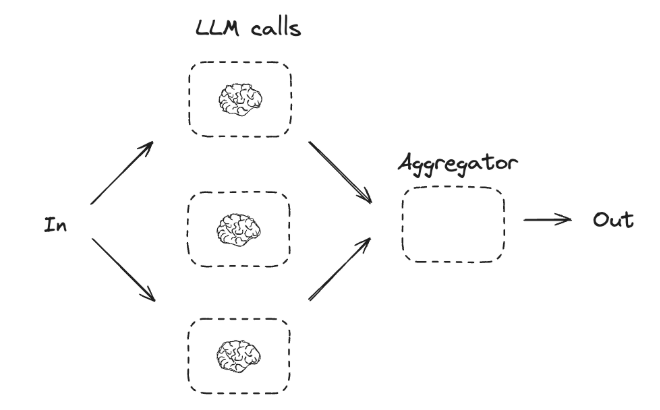

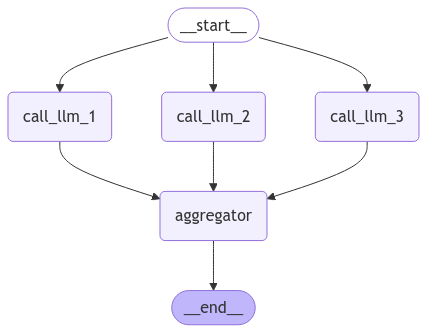

Here's a story, joke, and poem about cats!

STORY:
**The Whiskered Kingdom**

In a small village nestled between rolling hills and dense forests, there existed a mystical realm where cats ruled supreme. The Whiskered Kingdom, as it was known, was a place of enchantment and wonder, where felines of all shapes and sizes roamed free.

At the heart of the kingdom was a magnificent cat named Luna, with eyes as bright as the stars and fur as soft as silk. She was the wise and just queen of the Whiskered Kingdom, loved by all her subjects for her kindness and wisdom.

Luna's kingdom was a place of beauty and magic, where cats could be found lounging in sunbeams, chasing butterflies, or exploring the secrets of the forest. There were cats of every color and pattern, from sleek black panthers to fluffy white kittens, and each one was unique and special in its own way.

One day, a young calico cat named Willow arrived in the kingdom, seeking refuge from a harsh and unforgiving world. She was a c

In [3]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# Define LLM
llm = ChatGroq(model="llama-3.2-11b-vision-preview",temperature=0)

# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

#### Routing

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

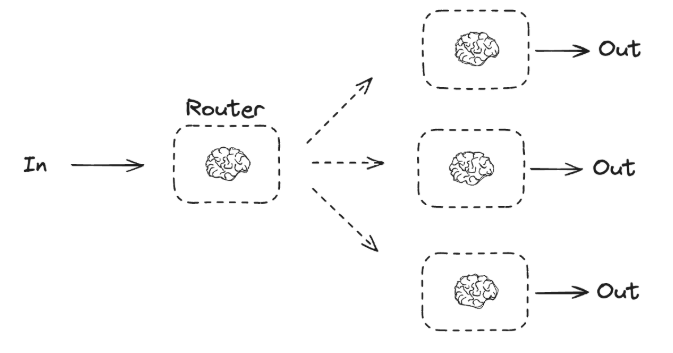

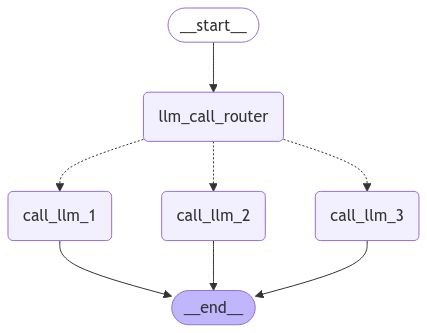

In [6]:
from pydantic import BaseModel
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

class Router(BaseModel):
    step : Literal["poem","story","joke"] = Field(None,description="The next step in the routing process")
    
# Define the LLM
llm = ChatGroq(model="llama-3.2-11b-vision-preview",temperature=0)

# Augment the LLM with the structured output
router = llm.with_structured_output(Router)

# Define the state
class State(TypedDict):
    input:str
    decision:str
    output:str
    
# Define the nodes
def call_llm_1(state:State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def call_llm_2(state:State):
    """Write a poem"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def call_llm_3(state:State):
    """Write a joke"""
    result = llm.invoke(state["input"])
    return {"output":result.content}


# Define the router logic
def llm_call_router(state:State):
    """Route the input to the respective node"""
    
    decision = router.invoke([
        SystemMessage(content="Route the input to story, joke or poem based on the user request"),
        HumanMessage(content=state["input"]),
    ])
    return {"decision":decision.step}


# Define conditional function to route the flow
def route_decision(state:State):
    if state["decision"].lower()=="poem":
        return "call_llm_2"
    elif state["decision"].lower() == "joke":
        return "call_llm_3"
    elif state["decision"].lower() == "story":
        return "call_llm_1"

# Build workflow
router_builder = StateGraph(State)
   
# Add nodes
router_builder.add_node("call_llm_1", call_llm_1)
router_builder.add_node("call_llm_2", call_llm_3)
router_builder.add_node("call_llm_3", call_llm_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "call_llm_1": "call_llm_1",
        "call_llm_2": "call_llm_2",
        "call_llm_3": "call_llm_3",
    },
)
router_builder.add_edge("call_llm_1", END)
router_builder.add_edge("call_llm_2", END)
router_builder.add_edge("call_llm_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Disply the workflow
router_workflow

In [9]:
# Invoke
response = router_workflow.invoke({"input":"Write a poem about the rainbow in marathi."})
response["output"]

"रंगोळी वाढते दिसते,\nपाण्यातून सूर्याची किरणे.\nलाल, निळा, पिवळा, पांढरा,\nगुलाबी आणि काळा, सारे रंग एकत्र.\n\nत्याच्या पलीकडे सृष्टी विस्तारते,\nप्राणी आणि पांडू, सारे जीव एकत्र.\nरंगोळीच्या पलीकडे सारे सुंदर,\nजीवनाचे सारे रंग एकत्र.\n\nरंगोळी वाढते दिसते,\nपाण्यातून सूर्याची किरणे.\nती आमच्या हृदयात जाते,\nआणि आम्हाला आनंद देते.\n\n(Translation: \n\nThe rainbow grows and appears,\nFrom the water, the sun's rays.\nRed, blue, yellow, white,\nPink and black, all colors together.\n\nBeyond the rainbow, the universe expands,\nAnimals and plants, all living beings together.\nBeyond the rainbow, all is beautiful,\nAll colors of life together.\n\nThe rainbow grows and appears,\nFrom the water, the sun's rays.\nIt enters our heart,\nAnd gives us joy.)\n\nNote: Marathi is a complex language with many nuances, and the translation may not fully capture the poetic essence of the original poem."

#### Orchestrator-Worker

In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

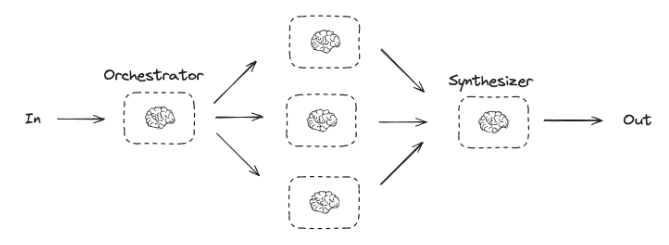

In [11]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

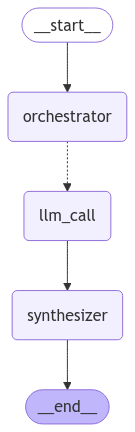

### Introduction and Description: Overview of Rohit Sharma's Early Life, Cricket Career, and Achievements

#### Early Life

Rohit Gurunath Sharma was born on April 30, 1987, in Banswadi, a small village in the Nagpur district of Maharashtra, India. He was the youngest of four children to Gurunath Sharma, a textile businessman, and Purnima Sharma. Rohit's early life was marked by a strong passion for cricket, which was encouraged by his father. He began playing cricket at a young age and was soon identified as a talented player by his school cricket coach.

#### Cricket Career

Rohit Sharma made his first-class debut for the Mumbai cricket team in 2005 and quickly established himself as a prolific run-scorer. He made his international debut for India in 2007 and has since become one of the most successful batsmen in the history of Indian cricket. Rohit has played in numerous international tournaments, including the ICC World Cup, the Indian Premier League (IPL), and the Champions Trophy.

#### Achievements

Throughout his career, Rohit Sharma has achieved numerous accolades and records. Some of his notable achievements include:

* **First Indian batsman to score five centuries in a single edition of the IPL**
* **First batsman to score a century in all three formats of the game (Test, ODI, and T20I)**
* **Highest individual score in an ODI (264 runs)**
* **Fastest century in ODI cricket (35.3 overs)**
* **Captain of the Indian national team in all formats of the game**
* **ICC ODI Player of the Year (2019)**
* **ICC T20I Player of the Year (2019)**

Rohit Sharma's impressive career has been marked by his exceptional batting skills, leadership qualities, and adaptability to different formats of the game. He continues to be one of the most dominant batsmen in international cricket.

---

### Career Highlights

#### Early Career

* Made his international debut in 2007 against Ireland
* Scored his first ODI century against Sri Lanka in 2007
* Made his Test debut against Sri Lanka in 2013

#### Notable Matches

* *Man of the Match* in the 2011 ICC Cricket World Cup final against Sri Lanka
* Scored 264 against Sri Lanka in the 2014 ICC World Cup, the highest individual score in ODI cricket at the time
* Scored 122 against Australia in the 2017 ICC Champions Trophy, helping India win the tournament
* Scored 119 against South Africa in the 2018 Nidahas Trophy, helping India win the tournament

#### Awards and Honors

* *ICC ODI Player of the Year* in 2017
* *ICC Test Player of the Year* in 2018
* *BCCI Cricketer of the Year* in 2010, 2017, and 2018
* *Arjuna Award* in 2015
* *Padma Shri* in 2017, India's fourth-highest civilian honor

#### Records and Milestones

* Fastest batsman to reach 7,000 runs in ODIs (143 innings)
* Fastest batsman to reach 2,000 runs in T20Is (49 innings)
* First batsman to score a century in all three formats (Test, ODI, and T20I)
* Highest individual score in ODI cricket (264 against Sri Lanka in 2014)

---

### Personal Life

#### Family

Rohit Sharma was born to Purnima Sharma and Gurunath Sharma. His father, Gurunath, was a truck driver, and his mother, Purnima, was a housewife. Rohit has a younger brother, Vishal, and a younger sister, Ishita.

#### Education

Rohit Sharma completed his primary education at Shimpoli School in Mumbai. He later attended Utpal Sanghvi School in Vile Parle, Mumbai, for his secondary education. Rohit's academic performance was not exceptional, but he was an avid cricket player from a young age.

#### Interests

Rohit Sharma is an avid cricket fan and enjoys playing various sports, including cricket, football, and badminton. He is also a fan of Bollywood music and movies. Rohit is known to be a foodie and enjoys trying different cuisines, especially street food from Mumbai.

---

### Impact on Indian Cricket

#### Introduction
Rohit Sharma's impact on Indian cricket has been significant, transforming the team's approach to batting and contributing to their success in various formats.

#### Leadership and Batting
As a skilled batsman and experienced leader, Rohit Sharma has played a crucial role in shaping the team's batting strategy. His ability to score runs at a high pace and adapt to different conditions has made him a valuable asset to the team. Under his leadership, the Indian team has become more aggressive and confident in their approach to batting.

#### Impact on Team Performance
Rohit Sharma's impact on the team's performance can be seen in the following areas:

* **Increased Run-Scoring**: Rohit's aggressive batting style has led to a significant increase in the team's run-scoring rate, making them a formidable opponent in all formats.
* **Improved Team Dynamics**: Rohit's leadership has brought a sense of calm and confidence to the team, which has led to improved team dynamics and a more cohesive unit.
* **Success in International Competitions**: Under Rohit's leadership, the Indian team has achieved success in various international competitions, including the ICC World Cup and the Asia Cup.

#### Challenges and Criticisms
While Rohit Sharma has had a significant impact on Indian cricket, there have been some challenges and criticisms surrounding his leadership and batting style. Some of these include:

* **Consistency**: Rohit has faced criticism for his inconsistent form, particularly in Test cricket.
* **Leadership Style**: Some critics have questioned Rohit's leadership style, suggesting that he is too laid-back and doesn't provide enough guidance to his teammates.
* **Batting Approach**: Rohit's aggressive batting style has been criticized by some, who feel that it is too reliant on individual brilliance and doesn't provide enough stability to the team's batting lineup.

#### Conclusion
In conclusion, Rohit Sharma's impact on Indian cricket has been significant, transforming the team's approach to batting and contributing to their success in various formats. While there have been some challenges and criticisms surrounding his leadership and batting style, Rohit remains one of the most important players in the Indian team and a key factor in their continued success.

---

### Conclusion and description: Summary of Rohit Sharma's achievements and legacy in cricket

#### Achievements in International Cricket

* **Most ODI centuries**: Rohit Sharma holds the record for the most ODI centuries with 32 centuries, surpassing Sachin Tendulkar's record of 49 years.
* **Highest individual score in ODI**: Rohit Sharma scored 264 runs in an ODI, the highest individual score in the format.
* **Most T20I centuries**: Rohit Sharma has scored 5 T20I centuries, the most by an Indian batsman.
* **Captaincy record**: Rohit Sharma has led India to several victories, including a series win in Australia and a T20 World Cup title in 2021.

#### Legacy in Cricket

* **Impact on Indian cricket**: Rohit Sharma's aggressive batting style and leadership have inspired a new generation of Indian cricketers.
* **Role model**: Rohit Sharma is considered a role model for young cricketers, known for his dedication, hard work, and sportsmanship.
* **Contribution to Indian cricket team**: Rohit Sharma has been a key player in the Indian cricket team, contributing significantly to the team's success in various formats.
* **Iconic status**: Rohit Sharma has become an iconic figure in Indian cricket, admired by fans and respected by his peers.

#### Impact on the Game

* **Influence on batting style**: Rohit Sharma's batting style has influenced a generation of batsmen, who have adopted his aggressive approach to the game.
* **Increased scoring rates**: Rohit Sharma's ability to score quickly has increased the scoring rates in international cricket, making the game more exciting for fans.
* **Inspiration to young players**: Rohit Sharma's success has inspired young players to work hard and pursue their dreams, creating a positive impact on the game.

#### Conclusion

Rohit Sharma's achievements and legacy in cricket are a testament to his hard work, dedication, and passion for the game. He has inspired a generation of cricketers and fans, leaving a lasting impact on the game.

In [14]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on the Rohit Sharma"})

from IPython.display import Markdown
Markdown(state["final_report"])

#### Evaluator-Optimizer LangGraph

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

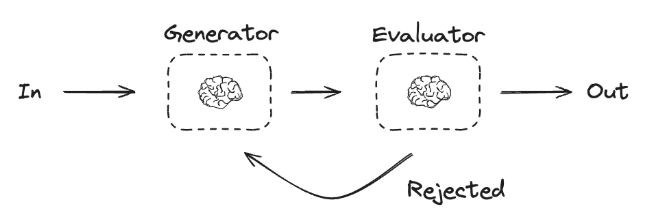

In [1]:
from langgraph.types import interrupt,Command
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from datetime import datetime

# LLM model
llm = ChatGroq(model="llama-3.2-11b-vision-preview",temperature=0)

# Define the memory checkpointer
memory = MemorySaver()

# Graph state
class State(TypedDict):
    joke: str
    topic: str
    llm_feedback: str
    human_feedback: str
    funny_or_not: str
    human_grade:str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Schema for structured output to use in human feedback evaluation
class HumanFeedback(BaseModel):
    grade: Literal["funny","not funny"] = Field(
        description="Based on provided feedback, decide joke is funny or not funny",
    )
    
# human feedback evaluator llm
human_evaluator = llm.with_structured_output(HumanFeedback)

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("llm_feedback") or state.get("human_feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the LLM feedback {state['llm_feedback']} and human feedback {state['human_feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade,"llm_feedback":grade.feedback}

def human_feedback(state:State):
    """Get the feedback from human"""
    human_feedback = interrupt("Hey! Do you feel it funny or not ?")
    state['human_feedback'] = human_feedback
    grade = human_evaluator.invoke(f"Grade the human feedback {human_feedback}")
    return {"human_feedback":human_feedback, "human_grade":grade.grade}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny" and state["human_grade"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny" and state["human_grade"] == "not funny":
        return "Rejected + Feedback"
    elif state["funny_or_not"] == "funny" and state["human_grade"] == "not funny":
        return "Rejected + Feedback"
    elif state["funny_or_not"] == "not funny" and state["human_grade"] == "funny":
        return "Accepted"
    
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)
optimizer_builder.add_node("human_feedback_evaluator", human_feedback)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_edge("llm_call_evaluator", "human_feedback_evaluator")

optimizer_builder.add_conditional_edges(
    "human_feedback_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile(checkpointer=memory)

# Show the workflow
# display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [2]:
type(optimizer_workflow)

langgraph.graph.state.CompiledStateGraph

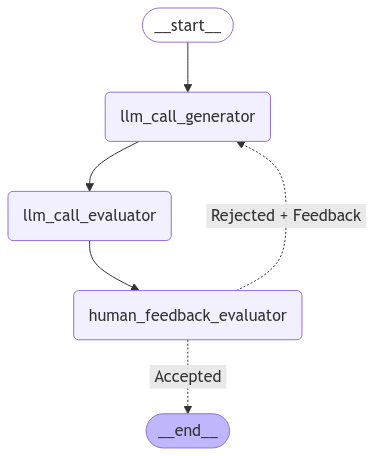

In [3]:
optimizer_workflow

In [17]:
# Define the config
config = {"configurable": {"thread_id": datetime.now().strftime("%Y%m%d%H%M%S%f")}}
print(config)
initial_input = {'topic':"umpires"}

{'configurable': {'thread_id': '20250223002924601962'}}


In [32]:
response = optimizer_workflow.invoke(
        {"topic": "umpires", "joke": "", "llm_feedback": "", "human_feedback": "", "funny_or_not": "", "human_grade": ""}, 
        config=config, 
        stream_mode="updates"
    )
response

[{'llm_call_generator': {'joke': 'Why did the umpire bring a ladder to the game?\n\nBecause he wanted to take his calls to a higher level.'}},
 {'llm_call_evaluator': {'funny_or_not': 'funny',
   'llm_feedback': "The joke is funny because it's a play on words, using the phrase 'higher level' in a literal sense to refer to the umpire's calls, rather than the usual figurative sense of improving something. It's a clever and unexpected twist that creates humor."}},
 {'__interrupt__': (Interrupt(value='Hey! Do you feel it funny or not ?', resumable=True, ns=['human_feedback_evaluator:88ecbd4a-5ecb-e4da-4220-ca25e1a6f120'], when='during'),)}]

In [31]:
for item in response:
    if '__interrupt__' in item:
        interrupt_msg = item.get('__interrupt__', None)[0].value
        print(interrupt_msg)

Hey! Do you feel it funny or not ?


In [ ]:
# # optimizer_workflow.invoke(initial_input,config,stream_mode="updates")

[{'llm_call_generator': {'joke': 'Why did the umpire bring a ladder to the game?\n\nBecause he wanted to take his calls to a higher level.'}},
 {'llm_call_evaluator': {'funny_or_not': 'funny',
   'llm_feedback': "The joke is funny because it's a play on words, using the phrase 'higher level' in a literal sense to refer to the umpire's calls, rather than the usual figurative sense of improving something. It's a clever and unexpected twist that creates humor."}},
 {'__interrupt__': (Interrupt(value='Hey! Do you feel it funny or not ?', resumable=True, ns=['human_feedback_evaluator:80ecf598-92dd-2ea5-165c-121c3622e24d'], when='during'),)}]

In [12]:
# stream the values
for event in optimizer_workflow.stream(initial_input, config = config, stream_mode="updates"):
    if event.get('llm_call_generator'):
        print(event.get('llm_call_generator')['joke'])
        print('\n')
    if event.get('__interrupt__'):
        print(event.get('__interrupt__')[0])
        print("\n")

Why did the umpire bring a ladder to the game?

Because he wanted to take his calls to a higher level.


Interrupt(value='Hey! Do you feel it funny or not ?', resumable=True, ns=['human_feedback_evaluator:ac753885-c10d-1b9e-a3b4-900904cfa2d0'], when='during')




In [13]:
human_feedback = optimizer_workflow.get_state(config).tasks[0].interrupts[0].value
human_feedback

'Hey! Do you feel it funny or not ?'

In [14]:
optimizer_workflow.invoke(Command(resume="The joke could have been better, make it more funnier."), config, stream_mode="updates")

[{'human_feedback_evaluator': {'human_feedback': 'The joke could have been better, make it more funnier.',
   'human_grade': 'not funny'}},
 {'llm_call_generator': {'joke': "Here's a revised joke about umpires:\n\nWhy did the umpire go to therapy? Because they were struggling to call balls and strikes at a higher level – literally, they were having trouble seeing over the players' heads.\n\nThis revised joke maintains the play on words, but adds a bit more context and a clearer punchline to make it funnier. The unexpected twist of the umpire struggling to see over the players' heads, rather than improving their calls, adds to the humor."}},
 {'llm_call_evaluator': {'funny_or_not': 'funny',
   'llm_feedback': "The revised joke is indeed funnier than the original. The added context and punchline create a clearer and more unexpected twist, which enhances the humor. The play on words is still present, but now it's more cleverly integrated into the joke. Well done!"}},
 {'__interrupt__': (I

In [16]:
optimizer_workflow.invoke(Command(resume="The joke could have been better, make it more funnier."), config)

{'joke': 'Here\'s a revised joke about umpires:\n\nWhy did the umpire go to therapy?\n\nBecause they were struggling to call balls and strikes at a higher level, and their therapist said, "Let\'s take it to a whole new level – literally, we\'re going to have to call in a structural engineer to inspect the strike zone."\n\nThis revised joke incorporates the play on words, using the phrase "higher level" in a literal sense to refer to the umpire\'s calls, while also referencing the idea of taking something to a higher level in a figurative sense. The punchline is unexpected and clever, making it amusing.',
 'topic': 'umpires',
 'llm_feedback': "The joke is funny because it uses a clever play on words, incorporating a literal and figurative meaning of 'higher level' to create an unexpected and amusing punchline. The addition of the structural engineer adds to the humor, making it a well-crafted joke.",
 'human_feedback': 'The joke could have been better, make it more funnier.',
 'funny_or

In [10]:
for event in optimizer_workflow.stream(
    Command(resume="The joke could have been better, make it more funnier."), config, stream_mode="updates"
):
    print(event)
    print("\n")

{'human_feedback_evaluator': {'human_feedback': 'The joke could have been better, make it more funnier.', 'human_grade': 'not funny'}}


{'llm_call_generator': {'joke': 'Here\'s a revised joke about umpires:\n\nWhy did the umpire go to therapy? Because they were struggling to call balls and strikes at a higher level – literally, they were having trouble seeing over the players\' heads.\n\nThis revised joke incorporates the play on words, using the phrase "higher level" in a literal sense to refer to the umpire\'s line of sight, rather than their skill or expertise. The unexpected twist creates humor by adding a physical element to the usual figurative meaning of the phrase.'}}


{'llm_call_evaluator': {'funny_or_not': 'funny', 'llm_feedback': "The joke is funny because it uses a clever play on words, incorporating a literal meaning of 'higher level' to create a humorous twist. The unexpected physical element adds to the humor, making it a well-crafted joke."}}


{'__interrupt__': (Inte

In [11]:
for event in optimizer_workflow.stream(
    Command(resume="This is good"), config, stream_mode="updates"
):
    print(event)
    print("\n")

{'human_feedback_evaluator': {'human_feedback': 'This is good', 'human_grade': 'funny'}}




In [38]:
feedback = "  Hrishi"
if not feedback.strip():
    print(True)